# U.S. Medical Insurance Costs

## Data Parsing
We have a csv file with insurance costs in the U.S., containing age, bmi, sex, number of children, smoker status, and geographical region. The following blocks of code load the data and saves it to relevant variables. 

`insurance_data` contains all of the csv data as a dictionary, with the key being the id (row index).
`ages`, `bmis`, `sexes`, `children_nums`, `smokers`, `regions`, and `costs` are all Numpy arrays containing the related data in the same order.

In [1]:
import csv
import numpy as np

In [2]:
insurance_data = {}

with open('insurance.csv') as insurance_csv:
    insurance_dict_reader = csv.DictReader(insurance_csv)
    for i, row in enumerate(insurance_dict_reader):
        insurance_data[i] = row  # The row number becomes the id.

print(f'Index 0 data: {insurance_data[0]}')
print(f'There are {len(insurance_data.keys())} datapoints in this dataset')

Index 0 data: {'age': '19', 'sex': 'female', 'bmi': '27.9', 'children': '0', 'smoker': 'yes', 'region': 'southwest', 'charges': '16884.924'}
There are 1338 datapoints in this dataset


In [3]:
# Initialize the data variables as empty lists.
ages = []
bmis = []
sexes = []
children_nums = []
smokers = []
regions = []
costs = []

# Add the data to each list.
for idx in range(len(insurance_data.keys())):
    ages.append(insurance_data[idx]['age'])
    bmis.append(insurance_data[idx]['bmi'])
    sexes.append(insurance_data[idx]['sex'])
    children_nums.append(insurance_data[idx]['children'])
    smokers.append(insurance_data[idx]['smoker'])
    regions.append(insurance_data[idx]['region'])
    costs.append(insurance_data[idx]['charges'])
    
# Convert data variables to Numpy arrays.
ages = np.array(ages, dtype=float)
bmis = np.array(bmis)
sexes = np.array(sexes)
children_nums = np.array(children_nums)
smokers = np.array(smokers)
regions = np.array(regions)
costs = np.array(costs)

print(f'First 10 ages: {ages[:10]}')

First 10 ages: [19. 18. 28. 33. 32. 31. 46. 37. 37. 60.]


## Linear Regression

In [4]:
def get_y(m, b, x):
    return m * x + b

In [5]:
def get_error(m, b, points):
    points_x = points[:, 0]
    points_y = points[:, 1]
    return np.abs(points_y - get_y(m, b, points_x))

In [6]:
def linear_regression(ms, bs, points):
    m_best = 0
    b_best = 0
    error = float('inf')
    for m in ms:
        for b in bs:
            if error < get_error(m, b, points).mean():
                continue
            error = get_error(m, b, points).mean()
            m_best = m
            b_best = b
    return m_best, b_best

## Age Analysis

In [7]:
from matplotlib import pyplot as plt

In [8]:
print(f'Average age: {ages.mean()}')

Average age: 39.20702541106129


In [9]:
# Find the unique ages, and then calculate the average cost per unique age
ages_unique = np.unique(ages)
avg_cost_per_age = np.array([np.array(costs[ages==i], dtype=float).mean() for i in ages_unique])
ages_costs = np.stack([ages_unique, avg_cost_per_age], axis=-1)

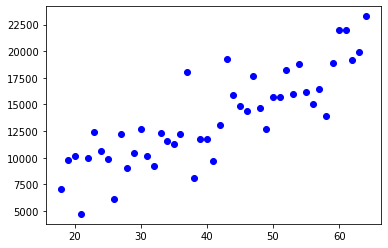

In [10]:
# Plot ages_costs to get rough idea of trendline
plt.plot(ages_costs[:, 0], ages_costs[:, 1], 'bo')
plt.show()

In [ ]:
# From that, we have rough idea of the correlation to get ms and bs for linear regression
ms = np.arange(200., 300., 0.1)
bs = np.arange(2500, 3500, 0.5)
m, b = linear_regression(ms, bs, ages_costs)
print(m, b, get_error(m, b, ages_costs).mean())

In [ ]:
# From the linear regression, we got m=253.5 and b=3078.5. Here, we'll plot that
predicted_ys = get_y(m, b, ages_costs[:, 0])
plt.plot(ages_costs[:, 0], ages_costs[:, 1], 'bo', ages_costs[:, 0], predicted_ys)
plt.show()